In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

In [3]:
import spacy
nlp = spacy.load('ja_ginza')
emb_dim = nlp("形態素").vector.shape[0]
emb_dim

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


300

In [4]:
def load_convs(path, filename):
    with open(path+filename, "r") as f:
        json_data = json.load(f)
        # length = json_data["length"]
        convs = json_data["convs"]
    return convs

In [5]:
cont_dir = "continue/"
cont_path = "../../corpus/nucc/" + cont_dir
length = 3
filename = "cont{0}.json".format(length)

In [6]:
convs = load_convs(cont_path, filename)

In [7]:
X_str = [conv for data in convs for conv in data]
X_utt = [utt for data in convs for conv in data for utt in conv]

In [8]:
import random
import copy
def fake_error(convs):
    utt_list = [conv[-1] for conv in convs]
    # print(utt_list)
    new_conv = copy.deepcopy(convs)
    for conv in new_conv:
        conv[-1] = random.choice(utt_list)
    return new_conv


In [9]:
UT = fake_error( X_str[:len(X_str)//2] ) 
UT_NO = X_str[len(X_str)//2:]
print("UT: {0}".format(len(UT)))
print("UT_NO: {0}".format(len(UT_NO)))

UT: 2876
UT_NO: 2876


In [10]:
# LSTM?
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True, bidirectional=True )
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        # self.softmax = 
    
    def forward(self, x):
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        batch_size, seq_len = x.shape[0], x.shape[1]
        _, hidden_layer = self.lstm(x)
        # print(hidden_layer)
        bilstm_out = torch.cat([hidden_layer[0][0], hidden_layer[0][1]], dim=1)
        # y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))

        y = self.hidden2tag(bilstm_out)
        y = F.log_softmax(y, dim=1)
        return y

In [11]:
import pickle
class DataManager:
    def __init__(self, data_path) -> None:
        import os
        import pickle
        self.data_path = data_path
        os.makedirs(data_path, exist_ok=True)
        self.dir = os.listdir(data_path)

    def is_exist(self, name):
        return (name in self.dir)
    
    def save_data(self, name, obj):
        with open(self.data_path+name, "wb") as f:
            pickle.dump(obj, f)
        print("success save : {0}{1}".format(self.data_path, name))

    def load_data(self, name):
        with open(self.data_path+name, "rb") as f:
            obj = pickle.load(f)
        print("success load : {0}{1}".format(self.data_path, name))
        return obj

In [12]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [13]:
from pyknp import Juman
from sentence_transformers import SentenceTransformer
import scipy.spatial
model_path = "/home/yamada/Downloads/training_bert_japanese"
Nmodel = SentenceTransformer(model_path, show_progress_bar=False)
emb_dim = Nmodel.encode(["お辞儀をしている男性会社員"])[0].shape[0]

In [14]:
def make_X(convs, max_len):
    # emb_dim = nlp("形態素").vector.shape
    X_data = []
    
    for conv in convs :
        # vec_list = np.zeros( (max_len, emb_dim[0]) )
        sentence_vectors = Nmodel.encode(conv)
        # for i, ut in enumerate(conv):
        #     doc = nlp(ut)
        #     vec_list[i] = doc.vector
        X_data.append(sentence_vectors)
    return np.array(X_data)

In [15]:
data_path = "../X_y_data/context/"
data_name = "topic3-{0}.pickle".format(length)
dataM = DataManager(data_path)
print(data_name)

topic3-3.pickle


In [16]:
if dataM.is_exist(data_name):
    
    DATA_Xy = dataM.load_data(data_name)
    X = DATA_Xy[0]
    y = DATA_Xy[1]
else:
    # X_data, y_data = pre.extract_X_y(df, error_types, seq_len)
    X = make_X(UT + UT_NO, length)
    y = np.concatenate( [ np.ones(len(UT)), np.zeros(len(UT_NO)) ] )
    dataM.save_data(data_name, [X, y])

success save : ../X_y_data/context/topic3-3.pickle


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [19]:
X_train = X_train[:-1]
y_train = y_train[:-1]
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

4600
1, 2, 4, 5, 8, 10, 20, 23, 25, 40, 46, 50, 92, 100, 115, 184, 200, 230, 460, 575, 920, 1150, 2300, 4600, 

In [20]:
BATCH_SIZE = 61
epoch_ = 230
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [22]:
EMBEDDING_DIM = emb_dim
HIDDEN_DIM = emb_dim*4
OUTPUT_DIM = 2
seq_len = length

In [23]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [24]:
losses = []
loss_border = 0.0001
# print("error[{0}]".format(error_types[error_i]))
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_t_tensor = torch.tensor(data[0], device='cuda:0').float()
        # y_t_tensor = torch.tensor(data[1].reshape(batch_size, 1), device='cuda:0').float()
        y_t_tensor = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)

        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
    # if all_loss <= loss_border:
    #     print("loss was under border(={0}) : train end".format(loss_border))
    #     break
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 50 	 loss 0.0003046695831017132
epoch 100 	 loss 2.2570955351852717e-05
epoch 150 	 loss 2.408027432565518e-06
epoch 200 	 loss 2.345100647005438e-08


KeyboardInterrupt: 

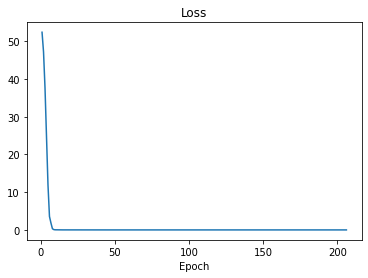

In [25]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [26]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [27]:
metrics.accuracy_score(y_test, y_pred)

0.7497827975673328

In [29]:
model_path = "../models/context/"
model_name = "topic3-{0}.pickle".format(length)
modelM = DataManager(model_path)
print(model_name)

topic3-3.pickle


In [30]:
modelM.save_data(model_name, model)

success save : ../models/context/topic3-3.pickle
